# Lab 11 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## GNN

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Implementar técncias de GNN para resolver um exemplo básico da aplicação do TF-GNN a um problema do mundo real, nomeadamente a classificação de moléculas para detecção de cardiotoxicidade.

um problema de classificação de texto tóxico em portugues.
- Utilizar *TensorFlow-GNN*.

Data da entrega : Fim do período

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/YvJsgo7ER72AmYV7A).

Este notebook é baseado em tensorflow e Keras.

Baseado neste [TUTORIAL](https://www.kaggle.com/code/fidels/introduction-to-tf-gnn).


# Introdução

Um [_graph_](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) consiste em uma coleção $\mathcal{V}={1,\dots,n}$ de nós, às vezes também chamados de vértices, e um conjunto de arestas $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$. Uma aresta $(i,j) \in \mathcal{E}$, também denotada por $i\to j$, representa uma relação do nó $i$ para o nó $j$, que, no caso geral, é direcionada (ou seja, não implica necessariamente na relação inversa $j\to i$). Grafos heterogêneos podem ter diferentes tipos de nós e/ou arestas, e grafos decorados podem ter características associadas aos seus nós, $h_i \in \mathbb{R}^{d_\mathcal{V}}$ para $i=1,\dots,n$, e/ou às suas arestas, $h_{i\to j} \in \mathbb{R}^{d_\mathcal{E}}$ para $(i,j)\in\mathcal{E}$.

Grafos são claramente um conceito muito geral que pode ser utilizado para representar muitos tipos diferentes de dados. Por exemplo, uma rede social e as cidades de um país.

[_Graph Neural Networks_ (GNN)](https://distill.pub/2021/gnn-intro/) são uma maneira pela qual podemos aplicar redes neurais a dados estruturados em grafo para aprender a fazer previsões sobre eles. Sua arquitetura normalmente envolve empilhar camadas de *message passing*, cada uma das quais atualiza as características de cada nó $i$ no grafo, aplicando alguma função às características de seus vizinhos, ou seja, todos os nós $j$ que têm arestas indo de $j$ para $i$.

[TensorFlow GNN (TF-GNN)](https://github.com/tensorflow/gnn) é uma adição relativamente recente ao ecossistema do TensorFlow, tendo sido lançado pela primeira vez no final de 2021. Em 2023, há relativamente poucos recursos disponíveis explicando como usar o TF-GNN na prática.

Um exemplo de aplicação de GNNs são problemas de classificação de grafos, nos quais somos incumbidos de prever a classe de um determinado grafo entre um conjunto finito de opções possíveis. No cenário supervisionado, temos um conjunto de grafos rotulados dos quais podemos aprender os parâmetros ${\theta_\mathcal{V}, \theta_{\mathcal{E}}}$ da GNN minimizando uma perda de entropia cruzada categórica para nossas previsões. Essas previsões são obtidas da GNN após aplicar uma última operação de agregação ou pooling sobre todos os nós, que mais uma vez deve ser sem ordem para preservar a propriedade importante de que a saída é invariante sob a reetiquetação dos nós.

## Problema a ser tratado






O objetivo desta prática é a classificação de moléculas que foram rotuladas como tóxicas ou não tóxicas no conjunto de dados CardioTox introduzido por:

<a id="cardiotox">[1]</a> K. Han, B. Lakshminarayanan and J. Liu, "Reliable Graph Neural Networks for Drug Discovery Under Distributional Shift," (arxiv:2111.12951)

Tomaremos os nós de nossos grafos como sendo os átomos em uma molécula, com as arestas representando ligações atômicas entre eles. Assim, nosso problema é uma classificação binária (porque temos apenas duas classes) em grafos homogêneos (porque temos apenas um tipo de nós e um tipo de arestas) que são ambos decorados com nós e arestas (porque, como será visto mais tarde, os dados contêm características para átomos e para as ligações entre eles).

# Importando bibliotecas e preparando o ambiente

Instalando dependências

In [1]:
from IPython.display import clear_output

# install non-Python dependencies
!apt-get -y install graphviz graphviz-dev

# Upgrade to TensorFlow 2.8
!pip install tensorflow==2.8 tensorflow-io==0.25.0 tfds-nightly pygraphviz

# Install TensorFlow-GNN
!pip install tensorflow_gnn==0.2.0

# Fix some dependencies
!pip install httplib2==0.20.4

clear_output()

Importando as bibliotecas

In [2]:
import pygraphviz as pgv
from tqdm import tqdm
from IPython.display import Image

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import tensorflow_gnn as tfgnn
import tensorflow_datasets as tfds

from tensorflow_gnn import runner
from tensorflow_gnn.models import gat_v2

print(f'Using TensorFlow v{tf.__version__} and TensorFlow-GNN v{tfgnn.__version__}')
print(f'GPUs available: {tf.config.list_physical_devices("GPU")}')

Using TensorFlow v2.8.0 and TensorFlow-GNN v0.2.0
GPUs available: []


 Vamos carregar a base de dados "*cardiotox*". Para detalhes sobre o dataset e o problema em si, veja o [link](https://www.tensorflow.org/datasets/catalog/cardiotox).

In [3]:
dataset_splits, dataset_info = tfds.load('cardiotox', data_dir='data/tfds', with_info=True)

clear_output()

print(dataset_info.description)

Drug Cardiotoxicity dataset [1-2] is a molecule classification task to detect
cardiotoxicity caused by binding hERG target, a protein associated with heart
beat rhythm. The data covers over 9000 molecules with hERG activity.

Note:

1. The data is split into four splits: train, test-iid, test-ood1, test-ood2.

2. Each molecule in the dataset has 2D graph annotations which is designed to
facilitate graph neural network modeling. Nodes are the atoms of the molecule
and edges are the bonds. Each atom is represented as a vector encoding basic
atom information such as atom type. Similar logic applies to bonds.

3. We include Tanimoto fingerprint distance (to training data) for each molecule
in the test sets to facilitate research on distributional shift in graph domain.

For each example, the features include:
  atoms: a 2D tensor with shape (60, 27) storing node features. Molecules with
    less than 60 atoms are padded with zeros. Each atom has 27 atom features.
  pairs: a 3D tensor with 

Para este exemplo, teremos apenas um conjunto de nós, que chamamos de `'átomo'`, e um conjunto de arestas, que chamamos de `'ligação'`. Naturalmente, todas as arestas têm nós do tipo `'átomo'` em ambas as extremidades. Tanto os nós quanto as arestas têm um único vetor de características, sendo o primeiro um vetor de características `'atom_features'` de 27 dimensões e o segundo um vetor de características `'bond_features'` de 12 dimensões. Além disso, os próprios grafos possuem características globais que fornecem seu contexto, neste caso uma classe de toxicidade `'toxicity'`, que é, na verdade, o rótulo que desejamos prever, e um identificador de molécula `'molecule_id'` que em grande parte ignoraremos.

Tudo mencionado acima pode ser codificado no seguinte esquema de grafo especificando a estrutura e o conteúdo de nossos grafos:

In [4]:
graph_schema_pbtxt = """
node_sets {
  key: "atom"
  value {
    description: "An atom in the molecule."

    features {
      key: "atom_features"
      value: {
        description: "[DATA] The features of the atom."
        dtype: DT_FLOAT
        shape { dim { size: 27 } }
      }
    }
  }
}

edge_sets {
  key: "bond"
  value {
    description: "A bond between two atoms in the molecule."
    source: "atom"
    target: "atom"

    features {
      key: "bond_features"
      value: {
        description: "[DATA] The features of the bond."
        dtype: DT_FLOAT
        shape { dim { size: 12 } }
      }
    }
  }
}

context {
  features {
    key: "toxicity"
    value: {
      description: "[LABEL] The toxicity class of the molecule (0 -> non-toxic; 1 -> toxic)."
      dtype: DT_INT64
    }
  }

  features {
    key: "molecule_id"
    value: {
      description: "[LABEL] The id of the molecule."
      dtype: DT_STRING
    }
  }
}
"""

In [30]:
graph_schema = tfgnn.parse_schema(graph_schema_pbtxt)
graph_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

## Pré-processando os dados

Precisamos converter os dados de entrada para um tipo de objeto `GraphTensor`. A seguinte função fará essa tarefa:

In [5]:
def make_graph_tensor(datapoint):
    """
    Convert a datapoint from the TF-DS CardioTox dataset into a `GraphTensor`.
    """
    # atom_mask is non-zero only for real atoms
    # [ V, ]
    atom_indices = tf.squeeze(tf.where(datapoint['atom_mask']), axis=1)

    # only keep features of real atoms
    # [ V, 27 ]
    atom_features = tf.gather(datapoint['atoms'], atom_indices)

    # restrict the bond mask to real atoms
    # [ V, V ]
    pair_mask = tf.gather(tf.gather(datapoint['pair_mask'], atom_indices, axis=0), atom_indices, axis=1)

    # restrict the bond features to real atoms
    # [ V, V, 12 ]
    pairs = tf.gather(tf.gather(datapoint['pairs'], atom_indices, axis=0), atom_indices, axis=1)

    # pair_mask is non-zero only for real bonds
    # [ E, 2 ]
    bond_indices = tf.where(pair_mask)

    # only keep features of real bonds
    # [ E, 12 ]
    bond_features = tf.gather_nd(pairs, bond_indices)

    # separate sources and targets for each bond
    # [ E, ]
    sources, targets = tf.unstack(tf.transpose(bond_indices))

    # active is [1, 0] for non-toxic molecules, [0, 1] for toxic molecules
    # [ ]
    toxicity = tf.argmax(datapoint['active'])

    # the molecule_id is included for reference
    # [ ]
    molecule_id = datapoint['molecule_id']

    # create a GraphTensor from all of the above
    atom = tfgnn.NodeSet.from_fields(features={'atom_features': atom_features},
                                     sizes=tf.shape(atom_indices))

    atom_adjacency = tfgnn.Adjacency.from_indices(source=('atom', tf.cast(sources, dtype=tf.int32)),
                                                  target=('atom', tf.cast(targets, dtype=tf.int32)))

    bond = tfgnn.EdgeSet.from_fields(features={'bond_features': bond_features},
                                     sizes=tf.shape(sources),
                                     adjacency=atom_adjacency)

    context = tfgnn.Context.from_fields(features={'toxicity': [toxicity], 'molecule_id': [molecule_id]})

    return tfgnn.GraphTensor.from_pieces(node_sets={'atom': atom}, edge_sets={'bond': bond}, context=context)

Uma vez que temos a função, podemos aplicá-la na base de dados para possuir um objeto do tipo `GraphTensor`.

In [6]:
train_dataset = dataset_splits['train'].map(make_graph_tensor)
val_dataset = dataset_splits['validation'].map(make_graph_tensor)
test_dataset = dataset_splits['test'].map(make_graph_tensor)

Vamos ver um exemplo:

In [7]:
graph_tensor = next(iter(train_dataset))
graph_tensor

GraphTensor(
  context=Context(features={'toxicity': <tf.Tensor: shape=(1,), dtype=tf.int64>, 'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atom'],
  edge_set_names=['bond'])

In [31]:
graph_spec.is_compatible_with(graph_tensor)

True

## Entendendo os dados

As características dos nós e das arestas não são particularmente ilustrativas, mas ainda assim podemos acessá-las diretamente se necessário. Primeiramente, observe que esta molécula em particular tem o seguinte número $V = |\mathcal{V}|$ de átomos:

In [8]:
graph_tensor.node_sets['atom'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([33], dtype=int32)>

As suas características são coletas em um tensor do formato `(V, 27)`, os quais podem ser acessados por:

In [9]:
graph_tensor.node_sets['atom']['atom_features']

<tf.Tensor: shape=(33, 27), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

Os IDs dos pontos finais das arestas são então armazenados em dois tensores de forma `(E,)`, onde `E` é a quantidade de arestas.

In [10]:
graph_tensor.edge_sets['bond'].adjacency.source

<tf.Tensor: shape=(68,), dtype=int32, numpy=
array([ 0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  7,  7,
        8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15,
       16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 23, 23, 23, 24, 25,
       25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 30, 31, 31, 31, 32],
      dtype=int32)>

In [11]:
graph_tensor.edge_sets['bond'].adjacency.target

<tf.Tensor: shape=(68,), dtype=int32, numpy=
array([ 1,  0,  2, 31,  1,  3, 23,  2,  4,  3,  5,  4,  6,  7,  5,  5,  8,
        7,  9,  8, 10,  9, 11, 12, 10, 10, 13, 12, 14, 13, 15, 14, 16, 17,
       15, 15, 18, 17, 19, 18, 20, 19, 21, 22, 20, 20,  2, 24, 25, 23, 23,
       26, 30, 25, 27, 26, 28, 27, 29, 28, 30, 25, 29, 31,  1, 30, 32, 31],
      dtype=int32)>

A seguinte função pode ser usada para visualizar o grafo.

In [12]:
def draw_molecule(graph_tensor):
    """
    Plot the `GraphTensor` representation of a molecule.
    """
    (molecule_id,) = graph_tensor.context['molecule_id'].numpy()
    (toxicity,) = graph_tensor.context['toxicity'].numpy()

    sources = graph_tensor.edge_sets['bond'].adjacency.source.numpy()
    targets = graph_tensor.edge_sets['bond'].adjacency.target.numpy()

    pgvGraph = pgv.AGraph()
    pgvGraph.graph_attr['label'] = f'toxicity = {toxicity}\n\nmolecule_id = {molecule_id.decode()}'

    for edge in zip(sources, targets):
        pgvGraph.add_edge(edge)

    return Image(pgvGraph.draw(format='png', prog='dot'))

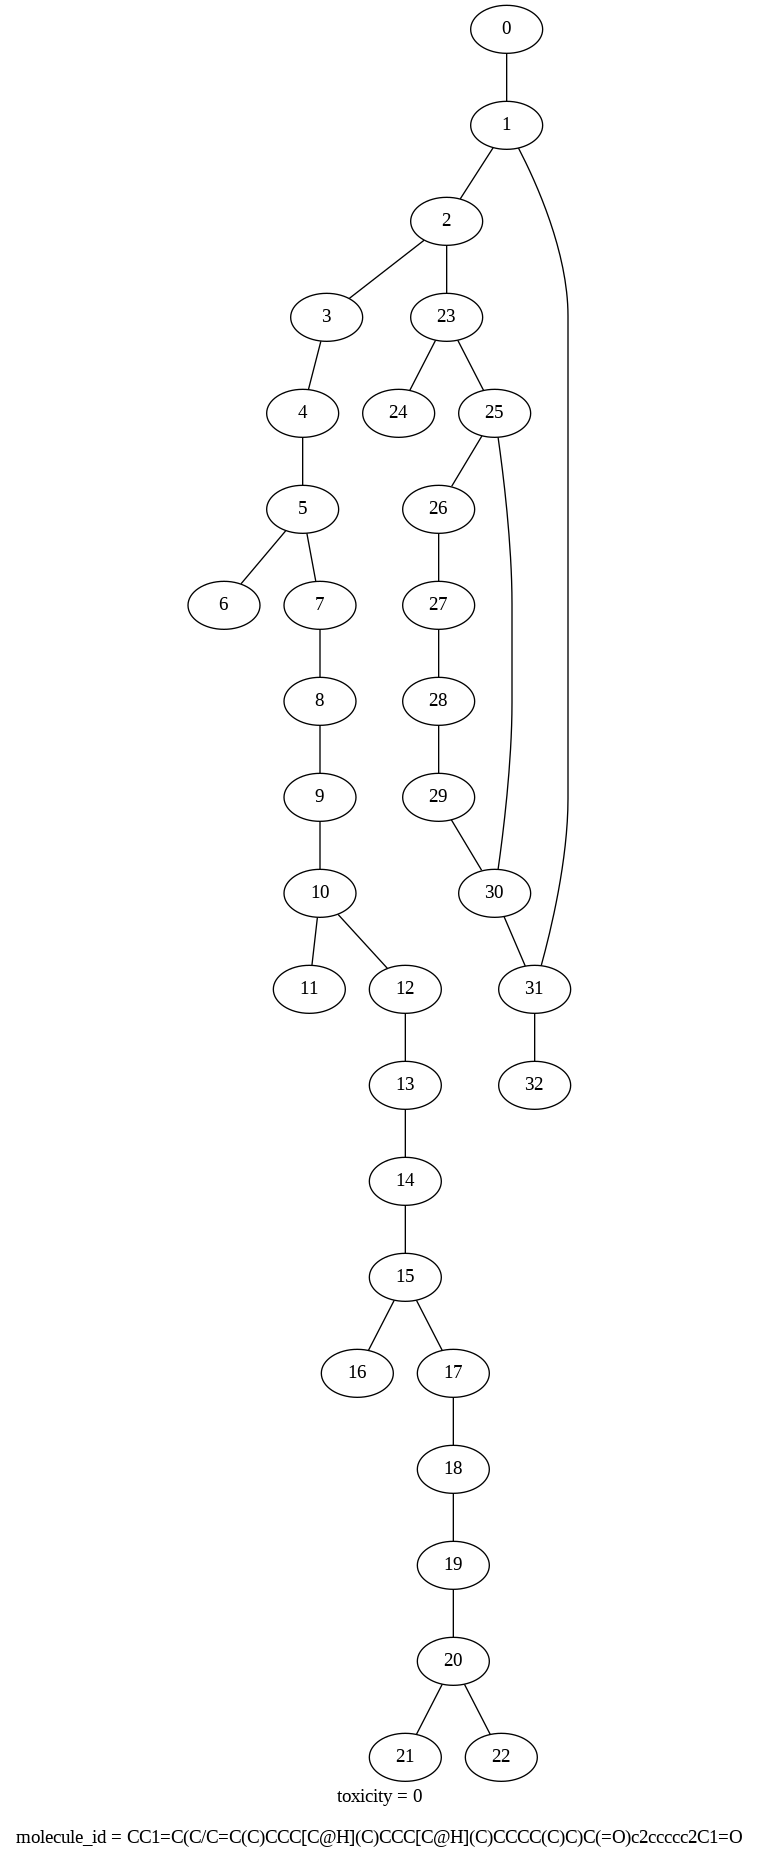

In [13]:
draw_molecule(graph_tensor)

# ToDo: Execute os passos da Seção 3 e da Seção 4 (não é necessário executar o caso 4.3).

Link para o tutorial: https://www.kaggle.com/code/fidels/introduction-to-tf-gnn

In [77]:
def get_initial_map_features(hidden_size, activation='relu'):
    """
    Initial pre-processing layer for a GNN (use as a class constructor).
    """
    def node_sets_fn(node_set, node_set_name):
        if node_set_name == 'atom':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(node_set['atom_features'])

    def edge_sets_fn(edge_set, edge_set_name):
        if edge_set_name == 'bond':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(edge_set['bond_features'])

    return tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                          edge_sets_fn=edge_sets_fn,
                                          name='graph_embedding')

class MPNN(tf.keras.layers.Layer):
    """
    A basic stack of message-passing Graph Attention layers.
    """
    def __init__(self, hidden_size, hops, name='gat_mpnn', **kwargs):
        self.hidden_size = hidden_size
        self.hops = hops
        super().__init__(name=name, **kwargs)

        self.mp_layers = [self._mp_factory(name=f'message_passing_{i}') for i in range(hops)]

    def _mp_factory(self, name):
        return gat_v2.GATv2GraphUpdate(num_heads=1,
                                       per_head_channels=self.hidden_size,
                                       edge_set_name='bond',
                                       sender_edge_feature=tfgnn.HIDDEN_STATE,
                                       name=name)

    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'hops': self.hops
        })
        return config

    def call(self, graph_tensor):
        for layer in self.mp_layers:
            graph_tensor = layer(graph_tensor)
        return graph_tensor

def vanilla_mpnn_model(graph_tensor_spec, init_states_fn, pass_messages_fn):
    """
    Chain an initialization layer and a message-passing stack to produce a `tf.keras.Model`.
    """
    graph_tensor = tf.keras.layers.Input(type_spec=graph_tensor_spec)
    embedded_graph = init_states_fn(graph_tensor)
    hidden_graph = pass_messages_fn(embedded_graph)
    return tf.keras.Model(inputs=graph_tensor, outputs=hidden_graph)

def get_model_creation_fn(hidden_size, hops, activation='relu', l2_coefficient=1e-3):
    """
    Return a model constructor for a given set of hyperparameters.
    """
    def model_creation_fn(graph_tensor_spec):
        initial_map_features = get_initial_map_features(hidden_size=hidden_size, activation=activation)
        mpnn = MPNN(hidden_size=hidden_size, hops=hops)

        model = vanilla_mpnn_model(graph_tensor_spec=graph_tensor_spec,
                                   init_states_fn=initial_map_features,
                                   pass_messages_fn=mpnn)
        model.add_loss(lambda: tf.reduce_sum([tf.keras.regularizers.l2(l2=l2_coefficient)(weight) for weight in model.trainable_weights]))
        return model
    return model_creation_fn

mpnn_creation_fn = get_model_creation_fn(hidden_size=128, hops=8)
model = mpnn_creation_fn(graph_spec)
model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [()]                      0         
                                                                 
 graph_embedding (MapFeature  ()                       5248      
 s)                                                              
                                                                 
 gat_mpnn (MPNN)             ()                        396288    
                                                                 
Total params: 401,536
Trainable params: 401,536
Non-trainable params: 0
_________________________________________________________________


# ToDo: Crie um novo modelo para classificação de Grafos (Passo 4.1 do tutorial).

In [82]:
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow.keras.layers import Dense

# Definir uma camada de inicialização de recursos do mapa
def get_initial_map_features(hidden_size, activation='relu'):
    def node_sets_fn(node_set, node_set_name):
        if node_set_name == 'atom':
            return Dense(units=hidden_size, activation=activation)(node_set['atom_features'])

    def edge_sets_fn(edge_set, edge_set_name):
        if edge_set_name == 'bond':
            return Dense(units=hidden_size, activation=activation)(edge_set['bond_features'])

    return tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                           edge_sets_fn=edge_sets_fn,
                                           name='graph_embedding')

# Definir uma camada de agregação global
class GlobalAggregation(tf.keras.layers.Layer):
    def __init__(self, reduce_type='mean', node_set_name='atom', **kwargs):
        super(GlobalAggregation, self).__init__(**kwargs)
        self.reduce_type = reduce_type
        self.node_set_name = node_set_name

    def call(self, graph_tensor):
        return tfgnn.keras.layers.GlobalPooling(reduce_type=self.reduce_type, node_set_name=self.node_set_name)(graph_tensor)

# Definir uma camada de classificação de grafos
class GraphClassificationModel(tf.keras.Model):
    def __init__(self, hidden_dim, num_classes, graph_tensor_spec, init_states_fn, pass_messages_fn):
        super(GraphClassificationModel, self).__init__()
        self.graph_embedding = init_states_fn
        self.mpnn = pass_messages_fn
        self.readout = GlobalAggregation(reduce_type='mean', node_set_name='atom', name='readout')
        self.hidden_layer = Dense(units=hidden_dim, activation='relu', name='hidden_layer')
        self.prediction_head = Dense(units=num_classes, activation='softmax', name='prediction_head')

    def call(self, inputs):
        embedded_graph = self.graph_embedding(inputs)
        hidden_graph = self.mpnn(embedded_graph)
        global_representation = self.readout(hidden_graph)
        hidden_state = self.hidden_layer(global_representation)
        logits = self.prediction_head(hidden_state)
        return logits

# Definir uma função para criar o modelo
def create_graph_classification_model(graph_spec):
    graph_embedding = get_initial_map_features(hidden_size=128)
    mpnn = tfgnn.layers.MPNN(hidden_size=128, hops=8)  # Corrigir o nome da classe
    model = GraphClassificationModel(hidden_dim=256, num_classes=2, graph_tensor_spec=graph_spec,
                                     init_states_fn=graph_embedding, pass_messages_fn=mpnn)
    return model

# Criar uma instância do modelo
graph_classification_model = create_graph_classification_model(graph_spec)

# Chamar build explicitamente para construir o modelo
graph_classification_model.build(input_shape=(None,))

# Verificar o resumo do modelo
graph_classification_model.summary()



AttributeError: module 'tensorflow_gnn' has no attribute 'layers'